In [1]:
using ProgressMeter
using JLD
using Random
using FlipPA
include("../alpcahus.jl")
include("../helperFunctions.jl")
include("../cluster.jl")

hungarianAlgorithm (generic function with 1 method)

In [2]:
D = 50 # ambient space dimension
d = 6 # subspace dimension
goodPoints = 6 # good points per subspace
ν1 = 0.1 # noise variance good points
K = 2 # subspace count
varianceRatio = 150 #150 #range( 1,300,5) # variance ratio for heatmaps
pointRatio = 50 #range(1,50,5) # point ratio between good bad data for heatmaps
trials = 100; # change to 100 for smoother results
qValue = 24;
dimensionVector = collect(1:12);

In [4]:
seedVector1 = rand(Xoshiro(1234), 1:100000, trials*length(dimensionVector));
seedVector2 = rand(Xoshiro(4321), 1:100000, trials*length(dimensionVector));
seedVector3 = rand(Xoshiro(2143), 1:100000, trials*length(dimensionVector));
seedVector4 = rand(Xoshiro(3412), 1:100000, trials*length(dimensionVector));

In [ ]:
alpcah_naive_vector = zeros(length(dimensionVector),trials)
alpcah_adaptiverank_vector = zeros(length(dimensionVector),trials)
alpcah_eigengap_vector = zeros(length(dimensionVector),trials)
noisy_oracle_vector = zeros(length(dimensionVector),trials)
estimate_rank_vector = zeros(length(dimensionVector),trials)
rankMatrix = zeros(length(dimensionVector), trials, 2)
rankMatrix_eigengap = zeros(length(dimensionVector), trials, 2)
rankMatrix_tips = zeros(length(dimensionVector), trials, 2)

count = 1
@showprogress 1 "Running..." for i = 1:length(dimensionVector) # varianceRatio
        for k = 1:trials
            # other parameters
            ν2 = varianceRatio*ν1
            badPoints = round(Int, pointRatio*goodPoints)
            # subspace generation
            U1 = generateSubspace(D, d; seed=seedVector1[count]) 
            U2 = generateSubspace(D, d; seed=seedVector2[count])
            # data generation
            X1 = generateData(U1, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector3[count])
            X2 = generateData(U2, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector4[count])
            # complete data matrix
            X = hcat(X1,X2);
            # cluster assignments
            C = vec([1*ones(size(X1)[2],1); 2*ones(size(X2)[2],1)]);
        
            # alpcahus RI
            estimatedCluster = ALPCAHUS(X,K, dimensionVector[i]*ones(Int,K); B=1, q=qValue, T=100, alpcahIter=20, subspaceMethod=:alpcah, finalStep=true, adaptiveRank=false, quantileAmount=0.95, spectralStart=false) 
            alpcah_naive_vector[i,k] = clusterError(C, estimatedCluster)

            # alpcahus FlipPA Method
            estimatedCluster = ALPCAHUS(X,K, dimensionVector[i]*ones(Int,K); B=1, q=qValue, T=100, alpcahIter=20, subspaceMethod=:alpcah, finalStep=true, adaptiveRank=true, quantileAmount=0.95, adaptiveMethod=:flippa) 
            alpcah_adaptiverank_vector[i,k] = clusterError(C, estimatedCluster)
            rankMatrix[i,k,1] = flippa(X[:,estimatedCluster .== 1]; quantile=0.95, trials=100)
            rankMatrix[i,k,2] = flippa(X[:,estimatedCluster .== 2]; quantile=0.95, trials=100)

            # alpcahus EIGENGAP
            estimatedCluster = ALPCAHUS(X,K, dimensionVector[i]*ones(Int,K); B=1, q=qValue, T=100, alpcahIter=20, subspaceMethod=:alpcah, finalStep=true, adaptiveRank=true, adaptiveMethod=:eigengap) 
            try
                alpcah_eigengap_vector[i,k] = clusterError(C, estimatedCluster)
            catch
                estimatedCluster = ALPCAHUS(X,K, dimensionVector[i]*ones(Int,K); B=1, q=qValue, T=100, alpcahIter=20, subspaceMethod=:alpcah, finalStep=true, adaptiveRank=true, adaptiveMethod=:eigengap)
                alpcah_eigengap_vector[i,k] = clusterError(C, estimatedCluster)
            end
            rankMatrix_eigengap[i,k,1] = argmax( -1*diff( reverse( eigen(X[:,estimatedCluster .== 1]*X[:,estimatedCluster .== 1]').values ) ) )
            rankMatrix_eigengap[i,k,2] = argmax( -1*diff( reverse( eigen(X[:,estimatedCluster .== 2]*X[:,estimatedCluster .== 2]').values ) ) )

            # estimate rank using spectral method
            estimatedCluster = TIPS(X, K; q=qValue)
            d1 = flippa(X[:,estimatedCluster .== 1]; quantile=0.95, trials=100)
            d2 = flippa(X[:,estimatedCluster .== 2]; quantile=0.95, trials=100)
            rankMatrix_tips[i,k,1] = d1
            rankMatrix_tips[i,k,2] = d2
            estimatedCluster = ALPCAHUS(X,K,[d1,d2]; B=1, q=qValue, T=100, alpcahIter=20, subspaceMethod=:alpcah, finalStep=true, adaptiveRank=false)
            estimate_rank_vector[i,k] = clusterError(C, estimatedCluster)
            
        
            # noisy oracle trial       
            noisyU1 = svd(X1[:,1:goodPoints]).U[:,1:d]
            noisyU2 = svd(X2[:,1:goodPoints]).U[:,1:d]
            estimatedCluster = 1 .+ Vector{Int8}(norm.(eachcol(noisyU1'*X)) .> norm.(eachcol(noisyU2'*X)));
            noisy_oracle_vector[i,k] = clusterError(C, estimatedCluster)
        
            # increase count
            count = count + 1
        end
end

In [31]:
#mean(skipmissing([1;2;3;missing;5]))

In [8]:
save("trialData.jld", "naive", alpcah_naive_vector, "adaptiveRank", alpcah_adaptiverank_vector,"oracle",noisy_oracle_vector,
    "ranks_flippa", rankMatrix, "ranks_eigen", rankMatrix_eigengap, "ranks_tips", rankMatrix_tips);

In [4]:
alpcah_naive_vector = load("trialData.jld", "naive")
alpcah_adaptiverank_vector = load("trialData.jld", "adaptiveRank")
noisy_oracle_vector = load("trialData.jld", "oracle")
rankMatrix = load("trialData.jld", "ranks_flippa")
rankMatrix_eigengap = load("trialData.jld", "ranks_eigen")
rankMatrix_tips = load("trialData.jld", "ranks_tips");

In [5]:
colors = theme_palette(:default)

In [6]:
noisy_oracle = mean(noisy_oracle_vector, dims=2) #mean(mean(noisy_oracle_vector, dims=2))
alpcah_naive = mean(alpcah_naive_vector, dims=2)
alpcah_adaptiverank = mean(alpcah_adaptiverank_vector, dims=2);
alpcah_eigengap = mean(alpcah_eigengap_vector, dims=2);
estimate_rank = mean(estimate_rank_vector, dims=2);

LoadError: UndefVarError: `alpcah_eigengap_vector` not defined

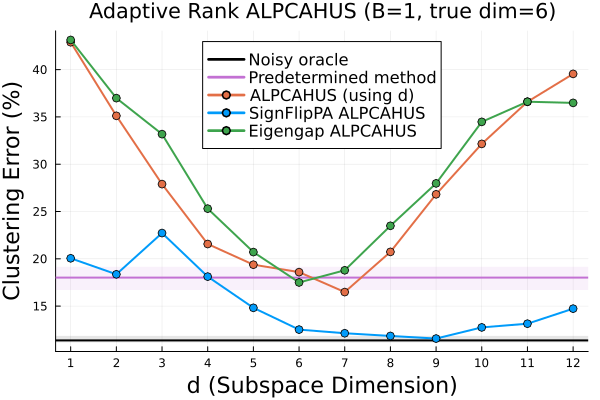

In [17]:
plot(title="Adaptive Rank ALPCAHUS (B=1, true dim=6)", xlabel="d (Subspace Dimension)", ylabel="Clustering Error (%)", legend=:top, fontsize = 15, guidefont=15, legendfont=11)
hline!([mean(noisy_oracle)], ribbon=(mean(noisy_oracle)-minimum(noisy_oracle), maximum(noisy_oracle)-mean(noisy_oracle)), label="Noisy oracle", color=:black, linewidth=2, fillalpha=0.1)
hline!([mean(estimate_rank)], ribbon=(mean(estimate_rank)-minimum(estimate_rank), maximum(estimate_rank)-mean(estimate_rank)),label="Predetermined method", color=colors[4], linewidth=2, fillalpha=0.1)
#plot!(noisy_oracle, label="Noisy Oracle", color=:black, linewidth=2, marker=:x)
#plot!(estimate_rank, label="Estimate with TIPS", color=:red, linewidth=2, marker=:x)
plot!(dimensionVector, alpcah_naive, label="ALPCAHUS (using d)", marker=:o, color=colors[2], linewidth=2, xticks=dimensionVector)
plot!(dimensionVector, alpcah_adaptiverank, label="SignFlipPA ALPCAHUS", marker=:o, color=colors[1], linewidth=2) # series_annotations = textArea
plot!(dimensionVector, alpcah_eigengap, label="Eigengap ALPCAHUS", marker=:o, color=colors[3], linewidth=2)
#savefig("adaptive_rank_clustering.pdf")

In [86]:
test = reshape(rankMatrix, (length(dimensionVector), :))
rankAmount_signflip = round.(Int,sum(test .== d, dims=2)/(trials*K)*100);

In [87]:
test = reshape(rankMatrix_eigengap, (length(dimensionVector), :))
rankAmount_eigengap = round.(Int,sum(test .== d, dims=2)/(trials*K)*100);

In [88]:
test = reshape(rankMatrix_tips, (length(dimensionVector), :))
rankAmount_tips = round.(Int,sum(test .== d, dims=2)/(trials*K)*100);

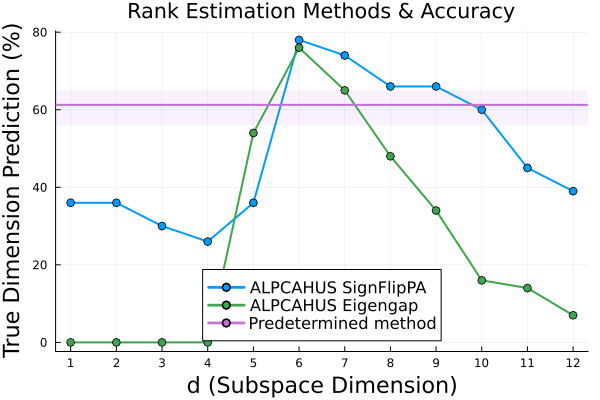

In [89]:
plot(xlabel="d (Subspace Dimension)", ylabel="True Dimension Prediction (%)", title="Rank Estimation Methods & Accuracy",legend=:bottom, fontsize = 15, guidefont=15, legendfont=11)
plot!(rankAmount_signflip, xticks=dimensionVector, marker=:o, label="ALPCAHUS SignFlipPA",linewidth=2)
plot!(rankAmount_eigengap, xticks=dimensionVector, marker=:o, label="ALPCAHUS Eigengap",linewidth=2, color=colors[3])
hline!([mean(rankAmount_tips)], ribbon=(mean(rankAmount_tips)-minimum(rankAmount_tips), maximum(rankAmount_tips)-mean(rankAmount_tips)), fillalpha=0.1, marker=:o, linewidth=2, color=colors[4],label="Predetermined method")
#savefig("adaptive_rank_prediction.pdf")

In [7]:
rankMatrix = load("trialData.jld", "ranks_flippa")
rankMatrix_eigengap = load("trialData.jld", "ranks_eigen")
rankMatrix_tips = load("trialData.jld", "ranks_tips")
rankMatrix_homo = load("trialData_homo.jld", "ranks_flippa")
rankMatrix_eigengap_homo = load("trialData_homo.jld", "ranks_eigen")
rankMatrix_tips_homo = load("trialData_homo.jld", "ranks_tips");

In [8]:
flippaMatrix = reshape(rankMatrix, (length(dimensionVector), :))
eigenMatrix = reshape(rankMatrix_eigengap, (length(dimensionVector), :));
index = [1, 3, 6, 9, 12]
flippaMatrix = flippaMatrix[index,:]
eigenMatrix = eigenMatrix[index,:]

5×200 Matrix{Float64}:
 1.0  1.0  1.0  1.0   1.0  1.0  1.0  …  1.0  1.0  1.0  1.0   1.0  1.0  1.0
 3.0  3.0  3.0  3.0   3.0  3.0  1.0     2.0  2.0  3.0  3.0   3.0  3.0  3.0
 5.0  6.0  6.0  6.0   6.0  1.0  6.0     1.0  6.0  1.0  6.0   6.0  6.0  1.0
 2.0  6.0  1.0  7.0  10.0  6.0  6.0     3.0  2.0  4.0  6.0   2.0  6.0  2.0
 6.0  1.0  1.0  1.0   1.0  3.0  1.0     2.0  1.0  2.0  5.0  12.0  1.0  2.0

In [23]:
colors = theme_palette(:default)

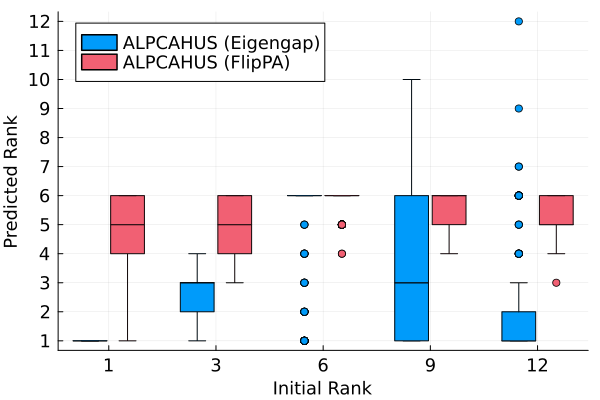

In [29]:
using StatsPlots
indexNew = vcat(rand(["1"], 200), rand(["3"], 200), rand(["6"], 200), rand(["9"], 200), rand(["12"], 200))
indexNew = vcat(indexNew, indexNew)
groupNew = vcat(rand(["ALPCAHUS (FlipPA)"], 1000), rand(["ALPCAHUS (Eigengap)"], 1000))
dataNew = vcat(vec(flippaMatrix'), vec(eigenMatrix'))
plot(title="", xlabel="Initial Rank", ylabel="Predicted Rank", legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=12,titlefontsize=18)
groupedboxplot!(indexNew, dataNew, group=groupNew, bar_width=0.7, legend=:topleft,  bar_position = :dodge,yticks=1:12, linewidth=1, color=[colors[1] colors[end-2]])
#savefig("adaptive_rank_boxplot.svg")

In [200]:
flippaMatrix = reshape(rankMatrix_homo, (length(dimensionVector), :))
eigenMatrix = reshape(rankMatrix_eigengap_homo, (length(dimensionVector), :));
index = [1, 3, 6, 9, 12]
flippaMatrix = flippaMatrix[index,:]
eigenMatrix = eigenMatrix[index,:];

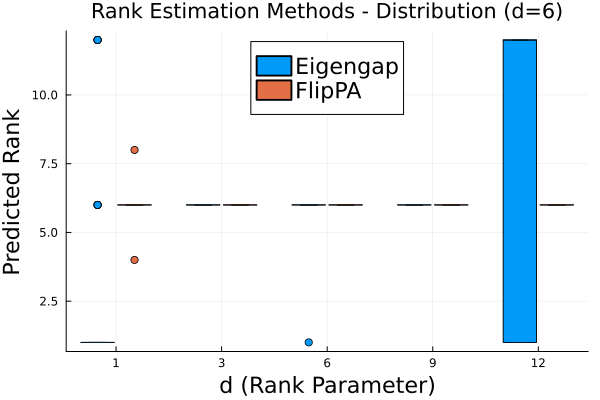

In [202]:
indexNew = vcat(rand(["1"], 200), rand(["3"], 200), rand(["6"], 200), rand(["9"], 200), rand(["12"], 200))
indexNew = vcat(indexNew, indexNew)
groupNew = vcat(rand(["FlipPA"], 1000), rand(["Eigengap"], 1000))
dataNew = vcat(vec(flippaMatrix'), vec(eigenMatrix'))
plot(title="Rank Estimation Methods - Distribution (d=6)", xlabel="d (Rank Parameter)", ylabel="Predicted Rank", legendfontsize=15, guidefontsize=15)
groupedboxplot!(indexNew, dataNew, group=groupNew, bar_width=0.7, legend=:top,  bar_position = :dodge, yticks=1:12)